In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-08-02 14:55:27.268288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Construct OPM

In [3]:
def gen_opm(sf,nk,N,seed=0):
    rng = np.random.default_rng(seed)
    
    x,y = np.meshgrid(np.arange(N)/N,np.arange(N)/N)

    z = np.zeros_like(x)
    
    for j in range(nk):
        fj = np.array([np.round(sf*np.cos(j*np.pi/nk)),
                       np.round(sf*np.sin(j*np.pi/nk))])
        sj = rng.choice([1,-1])
        phij = rng.random()*2*np.pi
        tmp = 2*np.pi*(x*fj[0]+y*fj[1])*sj + phij
        z = z + np.exp(1j * tmp)
        
    return z / nk

In [31]:
N4 = 120
z = gen_opm(12,24,N4)

Text(0.5, 1.0, 'Orientation Selectivity')

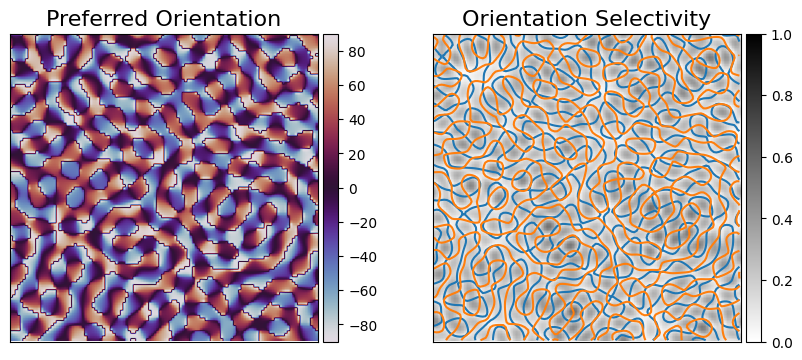

In [32]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

pf.imshowbar(fig,axs[0],np.angle(z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[1],np.abs(z),origin='lower',cmap='binary',vmin=0,vmax=1)
rcont = axs[1].contour(np.real(z),levels=[0],colors="C0")
icont = axs[1].contour(np.imag(z),levels=[0],colors="C1")
# pws = np.where(np.abs(z)<0.1)
# axs[1].scatter(pws[1],pws[0],c='r')

axs[0].set_title('Preferred Orientation',fontsize=16)
axs[1].set_title('Orientation Selectivity',fontsize=16)

# Calculate pinwheel density of OPM

## Calculate hypercolumn size

In [33]:
ori = np.angle(z)*180/(2*np.pi)
sel = np.abs(z)
z_unit = z / sel
ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(ori - np.nanmean(ori))))
z_unit_fft = np.abs(np.fft.fftshift(np.fft.fft2(z_unit - np.nanmean(z_unit))))
# ori_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# z_unit_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
ori_fps = np.zeros(N4//2)
z_unit_fps = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)
for idx in range(N4//2):
    ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
    z_unit_fps[idx] = np.mean(z_unit_fft[bin_idxs == idx])

Text(0.5, 1.0, 'FFT of Normalized Z Field')

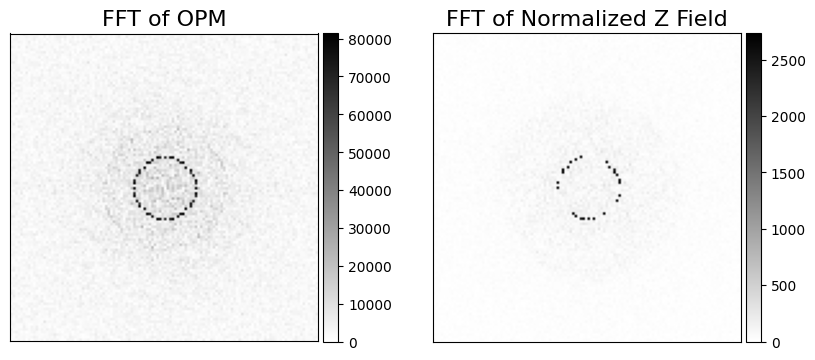

In [34]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

pf.imshowbar(fig,axs[0],ori_fft,cmap='binary')
pf.imshowbar(fig,axs[1],z_unit_fft,cmap='binary')

axs[0].set_title('FFT of OPM',fontsize=16)
axs[1].set_title('FFT of Normalized Z Field',fontsize=16)

(0.0, 23.96649839447293)

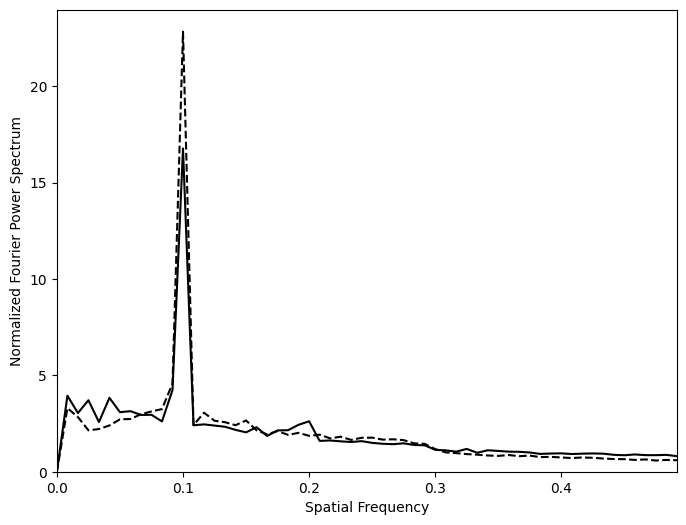

In [35]:
fig,axs = plt.subplots(1,1,figsize=(8,6))

# freqs = np.arange(int(np.ceil(N4//2*np.sqrt(2))))/N4
freqs = np.arange(N4//2)/N4

axs.plot(freqs,ori_fps/np.sum(ori_fps)*N4,'k')
axs.plot(freqs,z_unit_fps/np.sum(z_unit_fps)*N4,'k--')

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

In [36]:
Lam = 1/freqs[np.argmax(z_unit_fps)]
print('Λ =',Lam)
print('Λ/L =',Lam/N4)

Λ = 10.0
Λ/L = 0.08333333333333333


## Calculate total number of zero-crossings in OPM

In [37]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def cross(A,B):
    return A[0]*B[1] - A[1]*B[0]

def intersectpt(A,B,C,D):
    qmp = [C[0]-A[0],C[1]-A[1]]
    r = [B[0]-A[0],B[1]-A[1]]
    s = [D[0]-C[0],D[1]-C[1]]
    rxs = cross(r,s)
    
    t = cross(qmp,s)/rxs
#     u = cross(qmp,r)/rxs
    
    return [A[0]+t*r[0],A[1]+t*r[1]]

In [38]:
rsegpts = []
for pts in rcont.allsegs[0]:
    for i in range(len(pts)-1):
        rsegpts.append([pts[i],pts[i+1]])
rsegpts = np.array(rsegpts)

isegpts = []
for pts in icont.allsegs[0]:
    for i in range(len(pts)-1):
        isegpts.append([pts[i],pts[i+1]])
isegpts = np.array(isegpts)

In [39]:
pwcnt = 0
pwpts = []

for rsegpt in rsegpts:
    for isegpt in isegpts:
        if intersect(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]):
            pwcnt += 1
            pwpts.append(intersectpt(rsegpt[0],rsegpt[1],isegpt[0],isegpt[1]))
pwpts = np.array(pwpts)

In [40]:
print('N =',pwcnt)

N = 456


Text(0.5, 1.0, 'Orientation Selectivity')

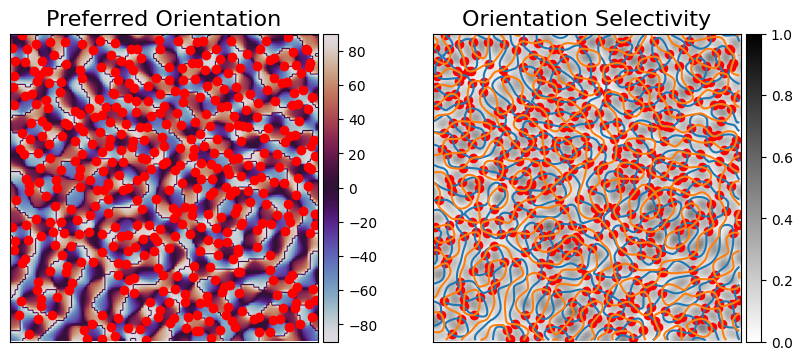

In [41]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

pf.imshowbar(fig,axs[0],np.angle(z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)
axs[0].scatter(pwpts[:,0],pwpts[:,1],c='r')

pf.imshowbar(fig,axs[1],np.abs(z),origin='lower',cmap='binary',vmin=0,vmax=1)
rcont = axs[1].contour(np.real(z),levels=[0],colors="C0")
icont = axs[1].contour(np.imag(z),levels=[0],colors="C1")
axs[1].scatter(pwpts[:,0],pwpts[:,1],c='r')

axs[0].set_title('Preferred Orientation',fontsize=16)
axs[1].set_title('Orientation Selectivity',fontsize=16)

## Calculate pinwheel density

In [42]:
print('ρ = N (Λ/L)² =',pwcnt * (Lam/N4)**2)

ρ = N (Λ/L)² = 3.1666666666666665
